In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download misrakahmed/vegetable-image-dataset

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0
 99% 528M/534M [00:04<00:00, 123MB/s]
100% 534M/534M [00:04<00:00, 121MB/s]


In [5]:
!pip install tensorflow

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
from zipfile import ZipFile


# Path to the downloaded zip file
dataset_zip_path = '/content/vegetable-image-dataset.zip'
# Path to extract the dataset
dataset_extract_path = '/content/dataset'

# Extract the dataset
with ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [8]:
# === Configuration ===
# Base directory for the dataset
base_dir = "/content/dataset/Vegetable Images"

# Directories for training, validation, and test sets
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "validation")
test_dir  = os.path.join(base_dir, "test")

# Image parameters and batch size
img_height, img_width = 224, 224
batch_size = 32

In [9]:
# === Data Augmentation and Generators ===
# For training data: include augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# For validation data: only rescaling is needed
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented image data from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode="categorical",
    shuffle=False  # To preserve the order if needed for evaluation
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [10]:
# Print class mapping (e.g., {"Bean": 0, "Broccoli": 1, "Carrot": 2})
num_classes = len(train_generator.class_indices)
print("Number of classes found:", num_classes)
print("Class indices mapping:", train_generator.class_indices)

Number of classes found: 15
Class indices mapping: {'Bean': 0, 'Bitter_Gourd': 1, 'Bottle_Gourd': 2, 'Brinjal': 3, 'Broccoli': 4, 'Cabbage': 5, 'Capsicum': 6, 'Carrot': 7, 'Cauliflower': 8, 'Cucumber': 9, 'Papaya': 10, 'Potato': 11, 'Pumpkin': 12, 'Radish': 13, 'Tomato': 14}


In [11]:
# === Building the Model Using Transfer Learning ===
# Load MobileNetV2 as the base model with pretrained ImageNet weights
base_model = MobileNetV2(weights="imagenet", include_top=False,
                         input_tensor=Input(shape=(img_height, img_width, 3)))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)       # Converts feature maps to a single 1280-element vector
x = Dropout(0.5)(x)                   # Helps reduce overfitting
predictions = Dense(num_classes, activation="softmax")(x)  # Final layer for classification

# Combine the base model and custom layers into one model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers so that only the top layers are trained initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Display the model architecture
model.summary()

<ipython-input-11-3eac4c6d3942>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# === Training the Model ===
epochs = 5  # You can increase this for better results

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

# Save the trained model for later use (inference or further fine-tuning)
model.save("vegetable_classifier.h5")

Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 864s 2s/step - accuracy: 0.9857 - loss: 0.0482 - val_accuracy: 0.9966 - val_loss: 0.0150
Epoch 2/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 141s 300ms/step - accuracy: 0.9688 - loss: 0.0728 - val_accuracy: 0.9970 - val_loss: 0.0148
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 923s 2s/step - accuracy: 0.9878 - loss: 0.0388 - val_accuracy: 0.9966 - val_loss: 0.0132
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 139s 295ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9966 - val_loss: 0.0131
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 872s 2s/step - accuracy: 0.9895 - loss: 0.0380 - val_accuracy: 0.9976 - val_loss: 0.0120


In [17]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


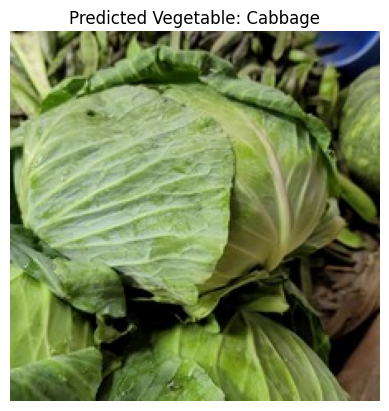

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Vegetable image: None
Predicted Vegetable: Cabbage


In [21]:
# Load the saved model
model = load_model("vegetable_classifier.h5")

# Get the mapping from class indices to labels from the training generator
# (Ensure that train_generator is available; otherwise, you can save and reload this mapping.)
labels = {v: k for k, v in train_generator.class_indices.items()}

def predict_vegetable(img_path):
    # Load the image with target size matching the training configuration
    img = image.load_img(img_path, target_size=(img_height, img_width))
    # Convert the image to a numpy array and expand dimensions to match model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Rescale the image as done during training
    img_array /= 255.0

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = labels[predicted_class]

    return predicted_label

def display_prediction(img_path):
    # Get prediction
    predicted_label = predict_vegetable(img_path)

    # Load the image for display (using matplotlib)
    img = plt.imread(img_path)

    # Display the image with title as the predicted label
    plt.imshow(img)
    plt.title(f"Predicted Vegetable: {predicted_label}")
    plt.axis("off")
    plt.show()

# Example usage:
test_image_path = "/content/dataset/Vegetable Images/test/Cabbage/0929.jpg"
result = display_prediction(test_image_path)
result1 = predict_vegetable(test_image_path)
print("Vegetable image:", result)
print("Predicted Vegetable:", result1)

In [ ]:
# Unfreeze the last 50 layers (for example)
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Continue training (fine-tuning)
fine_tune_epochs = 5
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=fine_tune_epochs
)